# Notebook Used to Vizualize the Output of Sequentially Saved Learning

In [1]:
from tqdm import tqdm
from scipy.spatial import distance
from dap import DAPcython
from dap.utils import obs_params, load_current
from utils import calc_features_ramp, calc_features_step

import warnings
warnings.filterwarnings("ignore")

In [2]:
import glob
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
dt = 1e-2
params, labels = obs_params(reduced_model=False)
data_dir = '/home/alteska/Desktop/LFI_DAP/data/rawData/2015_08_26b.dat'

### Get the dir names

In [4]:
# load the file
directory = './parameters/'
dir = glob.glob(directory + '*')
fname = dir[0] + '/'

In [5]:
fname

'./parameters/dap_model_step_11_param_2x132/'

## Load The Recorded Means and Std
'hyperparam.csv'
'parameters_mean.csv'
'parameters_std.csv'

In [6]:
df_std = pd.read_csv(fname + 'parameters_std' + '.csv')
df_mean = pd.read_csv(fname + 'parameters_mean' + '.csv')
df_hyperparam = pd.read_csv(fname + 'hyperparam' + '.csv')

In [7]:
df_mean.rename(columns={'Unnamed: 0':'id'}, inplace=True)
df_std.rename(columns={'Unnamed: 0':'id'}, inplace=True)
df_mean.set_index('id', inplace=True)
df_std.set_index('id', inplace=True)


In [8]:
#how to drop a param if needed
# df_mean.drop(15, inplace=True)
# df_mean.drop(16, inplace=True)
# df_mean.drop(17, inplace=True)

In [9]:
df_hyperparam

,Unnamed: 0,name,n_rounds,n_summary,n_samples,n_hidden,n_components,protocol,ramp_amp,prior_min,prior_max
0,0,_step_11_param_2x132,20,17,1000,"[132, 132]",1,IV,1,"[0, 1]","[0.5, 30]"


### Simulate For Each Parameter Set

### calculate DAP

In [10]:
# load the input data
Ir, vr, tr, t_onr, t_offr, dtr = load_current(data_dir, protocol='rampIV', ramp_amp=3.1)
Is, vs, ts, t_ons, t_offs, dts = load_current(data_dir, protocol='IV', ramp_amp=1)

In [11]:
### Set up themodel
params, labels = obs_params(reduced_model=True)
dap = DAPcython(-75, params)
U_ramp = dap.simulate(dtr, tr, Ir)
U_step = dap.simulate(dts, ts, Is)

In [12]:
# get traces for both currents
U_steps, U_ramps = [], []

for i, j in tqdm(df_mean.iterrows()):
    # get parameters
    par_temp = j.values

    # define a model
    dap = DAPcython(-75, j)

    # run model
    U_step_x = dap.simulate(dts, ts, Is)
    U_ramp_x = dap.simulate(dtr, tr, Ir)

    # run model
    U_steps.append(U_step_x.transpose()[0])
    U_ramps.append(U_ramp_x.transpose()[0])

20it [00:23,  1.14s/it]


### Viz all simulations

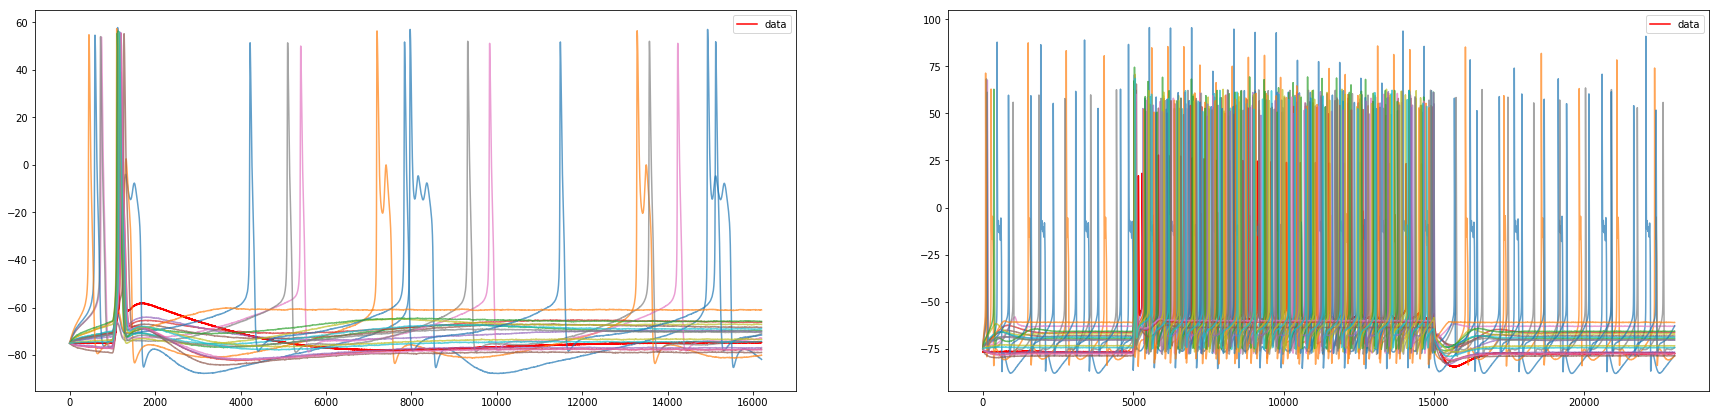

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(30, 7))

ax[0].plot(vr, c='r', label='data');
ax[1].plot(vs, c='r', label='data');

for i, trace in enumerate(U_ramps): 
    ax[0].plot(trace, alpha=0.7)

for i, trace in enumerate(U_steps): 
    ax[1].plot(trace, alpha=0.7)
    
ax[0].legend()
ax[1].legend();


## Calculate Similarity by Features

In [14]:
# create DataFrames for traces
df_step = pd.DataFrame({'step_traces': U_steps})
df_step.set_index(df_mean.index.values, inplace=True)

df_ramp = pd.DataFrame({'ramp_traces': U_ramps})
df_ramp.set_index(df_mean.index.values, inplace=True)

In [15]:
df_traces_temp = pd.merge(df_mean, df_step, how='left', left_index=True, right_index=True)
df_traces = pd.merge(df_traces_temp, df_ramp, how='left', left_index=True, right_index=True)

In [16]:
# Calculate Statistics for Ramp and Step currents
step_features_labels = ['rest_pot', 'rest_pot_std','firing_rate', 'ISI_mean', 'ISI_std', 'spike_count', 'spike_times_stim']
ramp_features_labels = ['rest_pot', 'AP_amp', 'AP_width', 'fAHP', 'DAP_amp', 'DAP_width', 'DAP_deflection','DAP_time', 'mAHP']

In [17]:
stats_step = []
for i,u in enumerate(U_steps):
    stats = calc_features_step(u, ts, dts, t_ons, t_offs)
    stats_step.append(stats)

In [18]:
stats_ramp = []
for i,u in enumerate(U_ramps):
    stats = calc_features_ramp(u, tr, dtr, t_onr, t_offr)
    stats_ramp.append(stats)

In [19]:
# change into data frame
df_ramps = pd.DataFrame(data=stats_ramp, columns=ramp_features_labels, index=df_mean.index)
df_steps = pd.DataFrame(data=stats_step, columns=step_features_labels, index=df_mean.index)

## Calculate The Features

In [20]:
data_feat_ramp = calc_features_ramp(vr, tr, dtr, t_onr, t_offr)
data_feat_ramp

array([-74.9345 , 113.997  ,   0.73   , -59.96875,  14.21575,  19.73   ,
        -0.75   ,   1.39   , -78.09375])

In [21]:
data_feat_step = calc_features_step(vs, ts, dts, t_ons, t_offs)
data_feat_step

array([-76.63358125, 0.06351057982730121, 48.0, 20.62173913043478,
       6.066798921122928, 24,
       array([254.6 , 258.4 , 264.6 , 275.95, 291.85, 309.  , 328.9 , 347.95,
       367.45, 387.1 , 409.75, 432.15, 456.4 , 479.25, 504.55, 527.35,
       552.55, 575.95, 600.95, 626.85, 651.45, 675.85, 703.5 , 728.9 ])],
      dtype=object)

## Create Comparison DF

#### Ramp Current

In [22]:
df_diff_ramps = np.abs(df_ramps.copy() - data_feat_ramp)
df_diff_ramps['sum'] = df_diff_ramps.sum(axis=1)
df_diff_ramps['sum'] = np.abs(df_diff_ramps['sum'])

df_diff_ramps.index.rename('id', inplace=True)
df_diff_ramps.reset_index(level=0, inplace=True)


#### Step Current

In [23]:
df_diff_steps = df_steps.dropna()
df_diff_steps.drop('spike_times_stim', axis=1, inplace=True)
df_diff_steps = np.abs(df_diff_steps - data_feat_step[:-1])

df_diff_steps.index.rename('id', inplace=True)
df_diff_steps.reset_index(level=0, inplace=True)
df_diff_steps['sum'] = df_diff_steps.drop('spike_count', axis=1).sum(axis=1)


### Pick The Best For Both Currents

In [24]:
n = 4
df_best_ramps = df_diff_ramps.sort_values('sum').head(n)
df_best_steps = df_diff_steps.sort_values('spike_count').head(n)

In [25]:
df_diff_steps

,id,rest_pot,rest_pot_std,firing_rate,ISI_mean,ISI_std,spike_count,sum
0,0,7.128679,29.746848,76.0,13.033215,5.126559,38.0,131.035301
1,1,5.771801,2.347586,62.0,11.605998,4.923419,31.0,87.648805
2,2,7.345158,0.035889,34.0,8.600489,5.857005,17.0,57.838541
3,3,10.411204,0.029191,8.0,2.290258,2.465766,4.0,26.196419
4,4,6.437253,0.013883,12.0,3.473463,2.736725,6.0,28.661325
5,5,8.617744,0.017871,20.0,6.058103,3.475859,10.0,43.169577
6,6,13.011203,0.032099,24.0,6.866025,4.430750,12.0,54.340077
7,7,8.161708,1.443635,36.0,8.682715,4.935970,18.0,66.224027
8,8,9.765475,0.037193,26.0,6.921739,6.097721,13.0,56.822129
9,9,7.940976,0.013995,10.0,3.482453,6.634209,5.0,37.071633


In [26]:
df_best_ramps

,id,rest_pot,AP_amp,AP_width,fAHP,DAP_amp,DAP_width,DAP_deflection,DAP_time,mAHP,sum
4,4,1.679597,14.703177,2.000000e-02,6.616881,7.872173,1.00,0.424305,0.81,3.084718,36.210851
3,3,2.655136,13.348439,3.000000e-02,7.847235,9.829155,4.79,0.673217,0.72,3.090674,42.983855
5,5,2.620290,13.829864,5.000000e-02,9.388486,11.420312,2.74,0.588464,0.69,3.082806,44.410222
19,19,0.307335,16.653991,1.776357e-15,9.895356,9.541533,7.33,0.661158,0.90,0.271607,45.560981


In [27]:
df_best_steps

,id,rest_pot,rest_pot_std,firing_rate,ISI_mean,ISI_std,spike_count,sum
13,14,0.245390,0.028575,6.0,4.135761,12.091638,3.0,36.501364
3,3,10.411204,0.029191,8.0,2.290258,2.465766,4.0,26.196419
17,19,2.270794,0.034949,10.0,3.325311,7.769488,5.0,42.400541
15,17,6.473326,0.032738,10.0,3.050311,5.959203,5.0,42.515578


## Merge With DFTraces to Get the best Traces and Parameters

In [28]:
names=['id','gbar_nap','gbar_leak','gbar_nat','gbar_kdr','gbar_hcn','ramp_traces', 'step_traces']

In [29]:
df_traces.head()

,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,gbar_hcn,nap_h_tau_max,nap_h_vs,nap_m_tau_max,nap_m_vs,kdr_n_tau_max,kdr_n_vs,step_traces,ramp_traces
id,,,,,,,,,,,,,
0,14.544604,0.808695,248.680210,3.252739,0.042721,17.296360,-16.897117,13.537603,17.162968,25.268577,18.844518,"[-75.00710470557576, -74.94457158163812, -74.8...","[-74.97295273282636, -74.9861543309981, -74.98..."
1,14.024941,0.984442,223.884983,3.203803,0.049546,16.031208,-17.098817,14.817797,17.986709,25.064446,19.147339,"[-74.99797908852305, -74.87883835772118, -74.7...","[-75.01761380956145, -74.97312652911985, -74.9..."
2,15.016931,0.969290,171.548670,3.416346,0.065181,14.982349,-18.582471,15.392292,16.939129,22.498832,17.931190,"[-75.00899580244828, -74.93103149980682, -74.8...","[-74.99074772053451, -74.97551711384688, -74.9..."
3,16.124227,0.986408,126.173180,3.210324,0.048364,13.882204,-19.165291,15.922973,16.583531,22.762991,17.952530,"[-75.0156952872464, -74.92981947004598, -74.84...","[-75.00307583131648, -74.97816818964921, -74.9..."
4,15.465965,0.949685,132.630608,3.096494,0.065359,13.227458,-18.815970,15.404399,16.302814,22.134550,18.342742,"[-74.99335769120854, -74.96714656900956, -74.8...","[-75.00903190315373, -74.99698592556861, -74.9..."


In [30]:
df_best_ramps.head()

,id,rest_pot,AP_amp,AP_width,fAHP,DAP_amp,DAP_width,DAP_deflection,DAP_time,mAHP,sum
4,4,1.679597,14.703177,2.000000e-02,6.616881,7.872173,1.00,0.424305,0.81,3.084718,36.210851
3,3,2.655136,13.348439,3.000000e-02,7.847235,9.829155,4.79,0.673217,0.72,3.090674,42.983855
5,5,2.620290,13.829864,5.000000e-02,9.388486,11.420312,2.74,0.588464,0.69,3.082806,44.410222
19,19,0.307335,16.653991,1.776357e-15,9.895356,9.541533,7.33,0.661158,0.90,0.271607,45.560981


In [31]:
# df_best_ramps.index.rename('id', inplace=True)
df_best_ramps.set_index('id', inplace=True)
df_best_steps.set_index('id', inplace=True)

In [32]:
df_best_ramp_tr = pd.merge(df_traces, df_best_ramps, left_index=True, right_index=True)
df_best_ramp_tr.head()

,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,gbar_hcn,nap_h_tau_max,nap_h_vs,nap_m_tau_max,nap_m_vs,kdr_n_tau_max,...,rest_pot,AP_amp,AP_width,fAHP,DAP_amp,DAP_width,DAP_deflection,DAP_time,mAHP,sum
id,,,,,,,,,,,,,,,,,,,,,
3,16.124227,0.986408,126.173180,3.210324,0.048364,13.882204,-19.165291,15.922973,16.583531,22.762991,...,2.655136,13.348439,3.000000e-02,7.847235,9.829155,4.79,0.673217,0.72,3.090674,42.983855
4,15.465965,0.949685,132.630608,3.096494,0.065359,13.227458,-18.815970,15.404399,16.302814,22.134550,...,1.679597,14.703177,2.000000e-02,6.616881,7.872173,1.00,0.424305,0.81,3.084718,36.210851
5,15.610656,0.969477,138.213406,3.156801,0.061912,13.640541,-19.011581,15.830542,16.480374,22.441984,...,2.620290,13.829864,5.000000e-02,9.388486,11.420312,2.74,0.588464,0.69,3.082806,44.410222
19,14.742494,1.054534,149.039218,3.270639,0.074809,14.473430,-17.939211,15.738022,16.197237,21.465190,...,0.307335,16.653991,1.776357e-15,9.895356,9.541533,7.33,0.661158,0.90,0.271607,45.560981


In [33]:
df_best_steps

,rest_pot,rest_pot_std,firing_rate,ISI_mean,ISI_std,spike_count,sum
id,,,,,,,
14,0.245390,0.028575,6.0,4.135761,12.091638,3.0,36.501364
3,10.411204,0.029191,8.0,2.290258,2.465766,4.0,26.196419
19,2.270794,0.034949,10.0,3.325311,7.769488,5.0,42.400541
17,6.473326,0.032738,10.0,3.050311,5.959203,5.0,42.515578


In [34]:

df_best_step_tr = pd.merge(df_traces, df_best_steps, left_index=True, right_index=True)
df_best_step_tr

,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,gbar_hcn,nap_h_tau_max,nap_h_vs,nap_m_tau_max,nap_m_vs,kdr_n_tau_max,kdr_n_vs,step_traces,ramp_traces,rest_pot,rest_pot_std,firing_rate,ISI_mean,ISI_std,spike_count,sum
id,,,,,,,,,,,,,,,,,,,,
3,16.124227,0.986408,126.173180,3.210324,0.048364,13.882204,-19.165291,15.922973,16.583531,22.762991,17.952530,"[-75.0156952872464, -74.92981947004598, -74.84...","[-75.00307583131648, -74.97816818964921, -74.9...",10.411204,0.029191,8.0,2.290258,2.465766,4.0,26.196419
14,14.630132,1.025666,139.753149,3.297524,0.051461,13.595211,-18.682281,15.436155,15.975457,23.400516,17.421530,"[-74.99740264905955, -75.0299686189737, -75.05...","[-75.02121413786193, -74.98979405052116, -74.9...",0.245390,0.028575,6.0,4.135761,12.091638,3.0,36.501364
17,14.254780,1.103166,144.926735,3.203493,0.049370,14.149926,-18.423077,15.661646,17.216326,22.376960,17.974478,"[-74.9983489159788, -74.94460716695896, -74.84...","[-74.99974022004598, -74.98465028091356, -75.0...",6.473326,0.032738,10.0,3.050311,5.959203,5.0,42.515578
19,14.742494,1.054534,149.039218,3.270639,0.074809,14.473430,-17.939211,15.738022,16.197237,21.465190,18.673695,"[-74.99883096407318, -75.02484751577448, -74.9...","[-75.01955637097295, -74.9804388179828, -74.97...",2.270794,0.034949,10.0,3.325311,7.769488,5.0,42.400541


## Visualize Best Results of Given Batch

### Ramp Current

In [35]:
df_best_ramp_tr

,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,gbar_hcn,nap_h_tau_max,nap_h_vs,nap_m_tau_max,nap_m_vs,kdr_n_tau_max,...,rest_pot,AP_amp,AP_width,fAHP,DAP_amp,DAP_width,DAP_deflection,DAP_time,mAHP,sum
id,,,,,,,,,,,,,,,,,,,,,
3,16.124227,0.986408,126.173180,3.210324,0.048364,13.882204,-19.165291,15.922973,16.583531,22.762991,...,2.655136,13.348439,3.000000e-02,7.847235,9.829155,4.79,0.673217,0.72,3.090674,42.983855
4,15.465965,0.949685,132.630608,3.096494,0.065359,13.227458,-18.815970,15.404399,16.302814,22.134550,...,1.679597,14.703177,2.000000e-02,6.616881,7.872173,1.00,0.424305,0.81,3.084718,36.210851
5,15.610656,0.969477,138.213406,3.156801,0.061912,13.640541,-19.011581,15.830542,16.480374,22.441984,...,2.620290,13.829864,5.000000e-02,9.388486,11.420312,2.74,0.588464,0.69,3.082806,44.410222
19,14.742494,1.054534,149.039218,3.270639,0.074809,14.473430,-17.939211,15.738022,16.197237,21.465190,...,0.307335,16.653991,1.776357e-15,9.895356,9.541533,7.33,0.661158,0.90,0.271607,45.560981


In [36]:
traces_ramp = df_best_ramp_tr.ramp_traces
traces_step = df_best_ramp_tr.step_traces
ids = df_best_ramp_tr.index

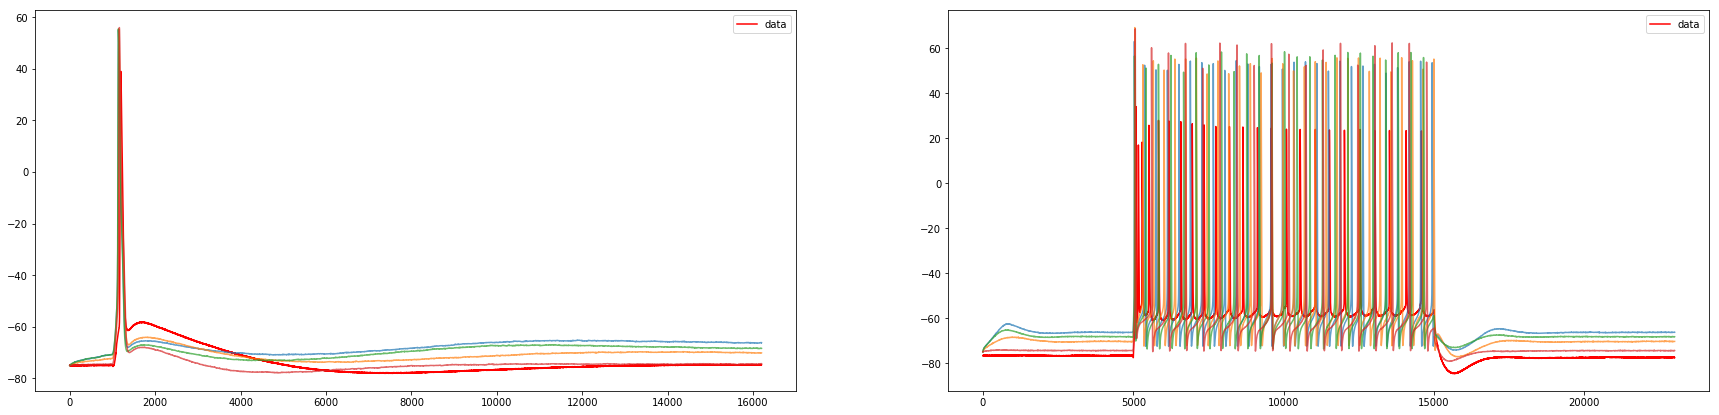

In [37]:
fig, ax = plt.subplots(ncols=2, figsize=(30, 7))

ax[0].plot(vr, c='r', label='data');

ax[1].plot(vs, c='r', label='data');

for i, tr in enumerate(traces_ramp): 
    ax[0].plot(tr, alpha=0.7)

for i, tr in enumerate(traces_step): 
    ax[1].plot(tr, alpha=0.7)
    
ax[0].legend()
ax[1].legend();



### Step Current

In [38]:
traces_ramp = df_best_step_tr.ramp_traces
traces_step = df_best_step_tr.step_traces
ids = df_best_step_tr.index

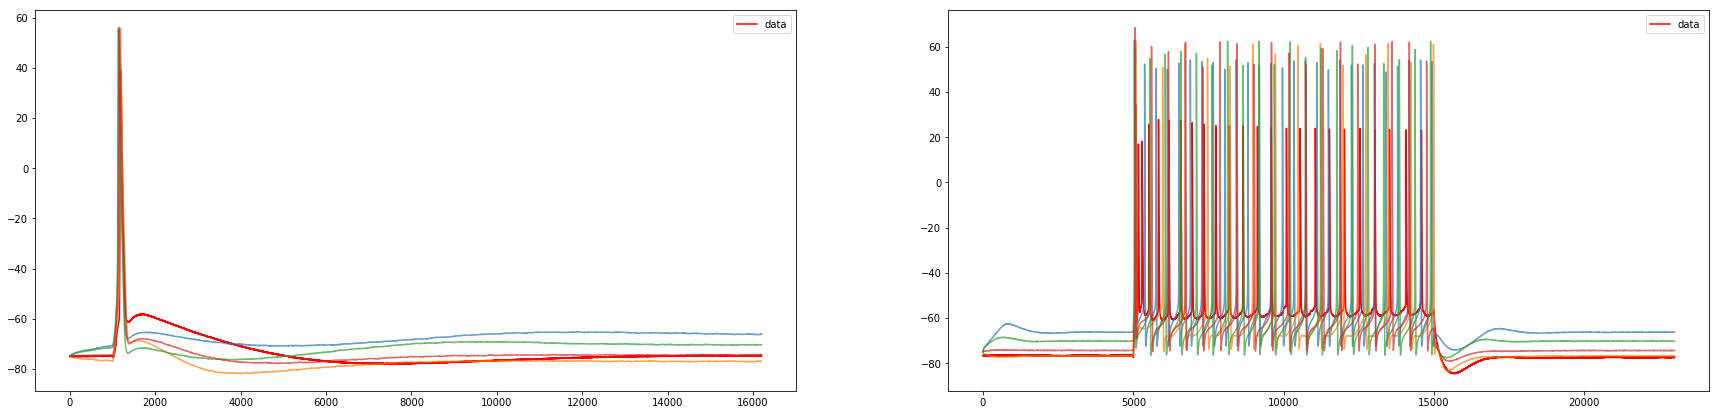

In [39]:
fig, ax = plt.subplots(ncols=2, figsize=(30, 7))

ax[0].plot(vr, c='r', label='data');
ax[1].plot(vs, c='r', label='data');

for i, tr in enumerate(traces_ramp): 
    ax[0].plot(tr, alpha=0.7)

for i, tr in enumerate(traces_step): 
    ax[1].plot(tr, alpha=0.7)
    
ax[0].legend()
ax[1].legend();


### Show the best Results

In [44]:
df_best_step_tr

,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,gbar_hcn,nap_h_tau_max,nap_h_vs,nap_m_tau_max,nap_m_vs,kdr_n_tau_max,kdr_n_vs,step_traces,ramp_traces,rest_pot,rest_pot_std,firing_rate,ISI_mean,ISI_std,spike_count,sum
id,,,,,,,,,,,,,,,,,,,,
3,16.124227,0.986408,126.173180,3.210324,0.048364,13.882204,-19.165291,15.922973,16.583531,22.762991,17.952530,"[-75.0156952872464, -74.92981947004598, -74.84...","[-75.00307583131648, -74.97816818964921, -74.9...",10.411204,0.029191,8.0,2.290258,2.465766,4.0,26.196419
14,14.630132,1.025666,139.753149,3.297524,0.051461,13.595211,-18.682281,15.436155,15.975457,23.400516,17.421530,"[-74.99740264905955, -75.0299686189737, -75.05...","[-75.02121413786193, -74.98979405052116, -74.9...",0.245390,0.028575,6.0,4.135761,12.091638,3.0,36.501364
17,14.254780,1.103166,144.926735,3.203493,0.049370,14.149926,-18.423077,15.661646,17.216326,22.376960,17.974478,"[-74.9983489159788, -74.94460716695896, -74.84...","[-74.99974022004598, -74.98465028091356, -75.0...",6.473326,0.032738,10.0,3.050311,5.959203,5.0,42.515578
19,14.742494,1.054534,149.039218,3.270639,0.074809,14.473430,-17.939211,15.738022,16.197237,21.465190,18.673695,"[-74.99883096407318, -75.02484751577448, -74.9...","[-75.01955637097295, -74.9804388179828, -74.97...",2.270794,0.034949,10.0,3.325311,7.769488,5.0,42.400541


In [47]:
n=3
u_ramp = df_best_step_tr.loc[[n]].ramp_traces[n]
u_step = df_best_step_tr.loc[[n]].step_traces[n]

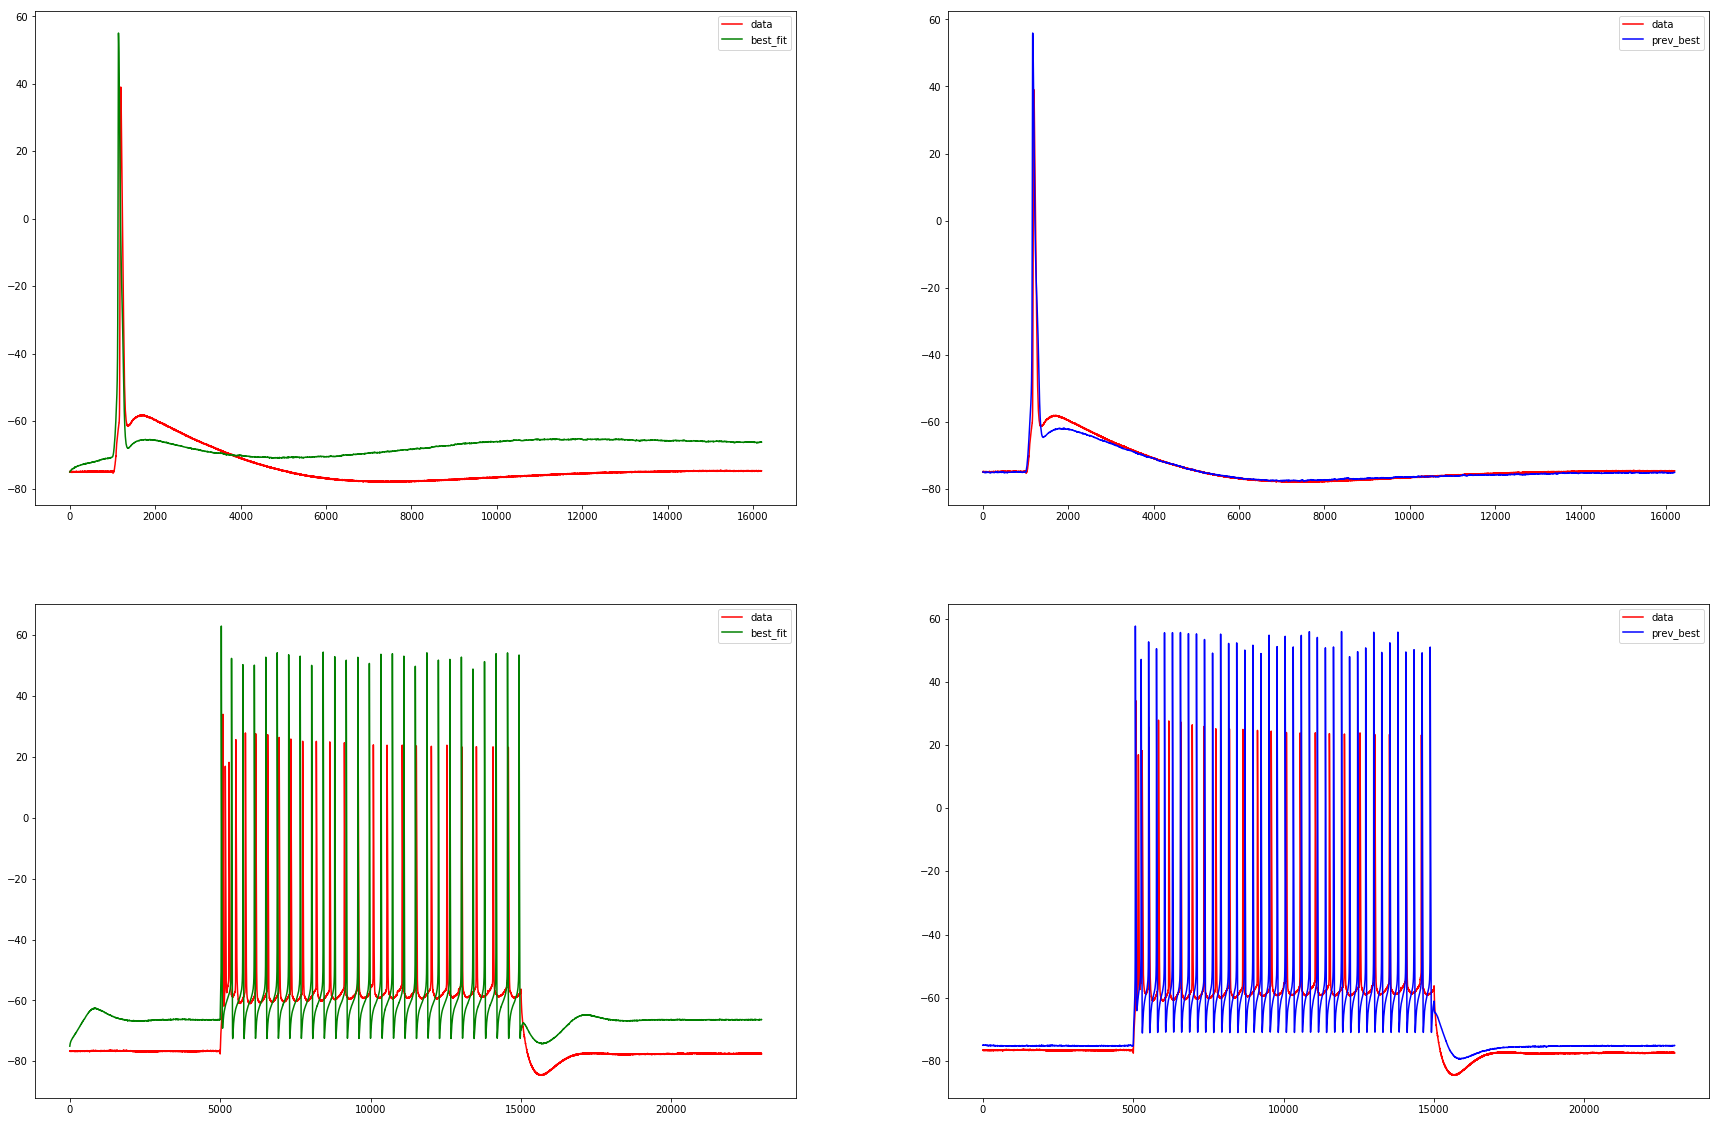

In [48]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(30, 20))

ax[0][0].plot(vr, c='r', label='data');
ax[0][1].plot(vr, c='r', label='data');
ax[1][0].plot(vs, c='r', label='data');
ax[1][1].plot(vs, c='r', label='data');

ax[0][0].plot(u_ramp, c='g', label='best_fit');
ax[1][0].plot(u_step, c='g', label='best_fit');

ax[0][1].plot(U_ramp, c='b', label='prev_best');
ax[1][1].plot(U_step, c='b', label='prev_best');

    
ax[0][0].legend()
ax[0][1].legend()
ax[1][0].legend();
ax[1][1].legend();

### Second Best Result

In [51]:
df_best_ramp_tr.sort_values('sum')

,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,gbar_hcn,nap_h_tau_max,nap_h_vs,nap_m_tau_max,nap_m_vs,kdr_n_tau_max,...,rest_pot,AP_amp,AP_width,fAHP,DAP_amp,DAP_width,DAP_deflection,DAP_time,mAHP,sum
id,,,,,,,,,,,,,,,,,,,,,
4,15.465965,0.949685,132.630608,3.096494,0.065359,13.227458,-18.815970,15.404399,16.302814,22.134550,...,1.679597,14.703177,2.000000e-02,6.616881,7.872173,1.00,0.424305,0.81,3.084718,36.210851
3,16.124227,0.986408,126.173180,3.210324,0.048364,13.882204,-19.165291,15.922973,16.583531,22.762991,...,2.655136,13.348439,3.000000e-02,7.847235,9.829155,4.79,0.673217,0.72,3.090674,42.983855
5,15.610656,0.969477,138.213406,3.156801,0.061912,13.640541,-19.011581,15.830542,16.480374,22.441984,...,2.620290,13.829864,5.000000e-02,9.388486,11.420312,2.74,0.588464,0.69,3.082806,44.410222
19,14.742494,1.054534,149.039218,3.270639,0.074809,14.473430,-17.939211,15.738022,16.197237,21.465190,...,0.307335,16.653991,1.776357e-15,9.895356,9.541533,7.33,0.661158,0.90,0.271607,45.560981


In [53]:
nn = 4 
u_ramp = df_best_ramp_tr.loc[[nn]].ramp_traces[nn]
u_step = df_best_ramp_tr.loc[[nn]].step_traces[nn]

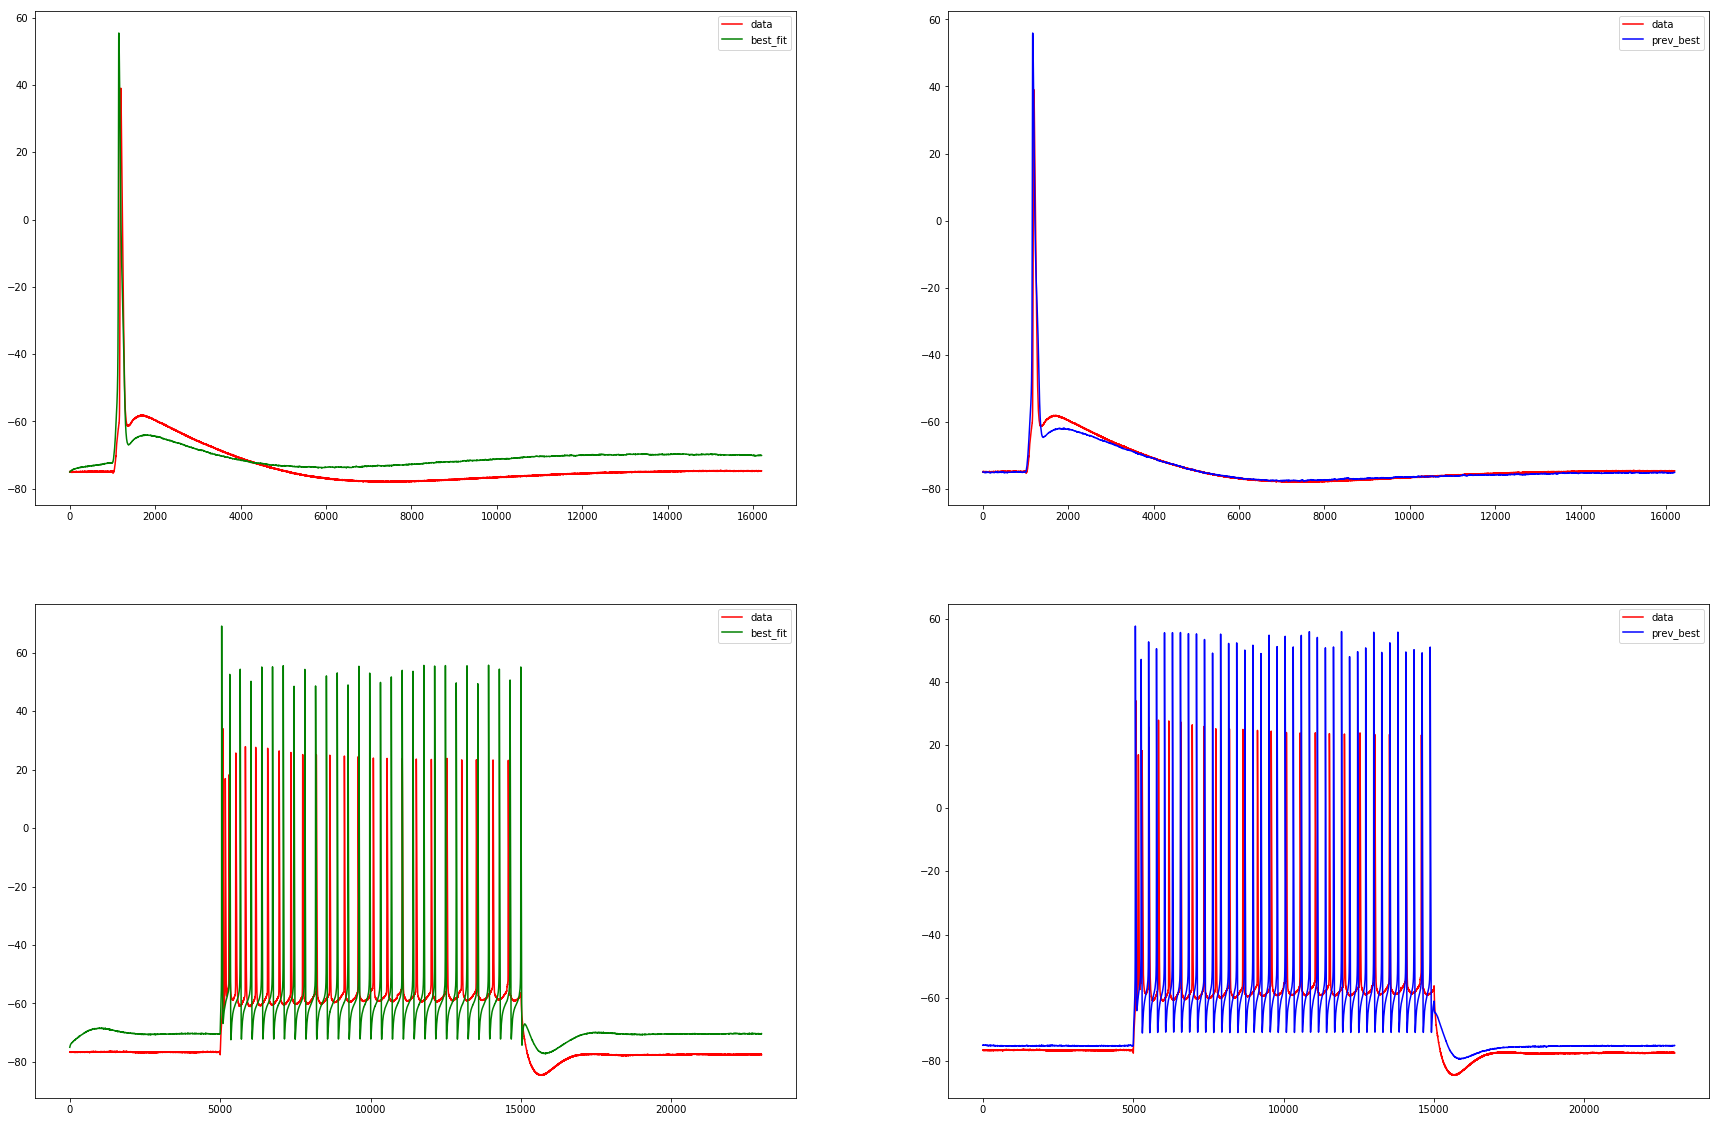

In [54]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(30, 20))

ax[0][0].plot(vr, c='r', label='data');
ax[0][1].plot(vr, c='r', label='data');
ax[1][0].plot(vs, c='r', label='data');
ax[1][1].plot(vs, c='r', label='data');

ax[0][0].plot(u_ramp, c='g', label='best_fit');
ax[1][0].plot(u_step, c='g', label='best_fit');

ax[0][1].plot(U_ramp, c='b', label='prev_best');
ax[1][1].plot(U_step, c='b', label='prev_best');

    
ax[0][0].legend()
ax[0][1].legend()
ax[1][0].legend();
ax[1][1].legend();

### Phase Plane: V ; dV/dt

ValueError: x and y must have same first dimension, but have shapes (23000,) and (16200,)

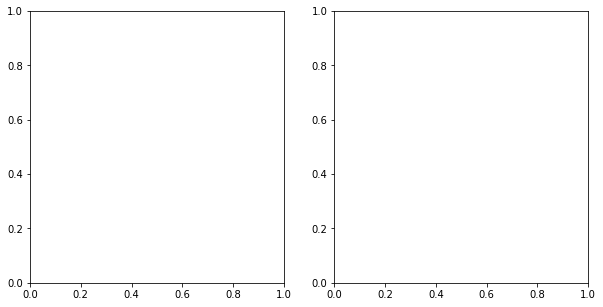

In [56]:
dvdt = np.gradient(u_ramp, dtr)

fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].plot(tr, u_ramp);
ax[1].plot(dvdt);

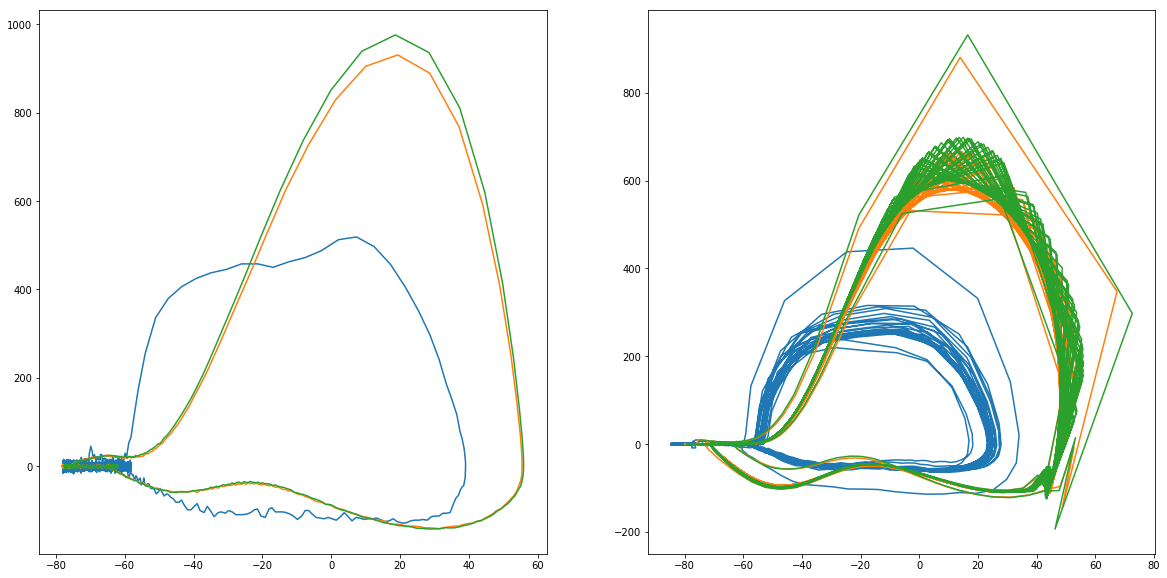

In [103]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))

ax[0].plot(vr, np.gradient(vr, dtr));
ax[0].plot(u_ramp, np.gradient(u_ramp, dtr));
ax[0].plot(U_ramp, np.gradient(U_ramp.T[0], dtr));

ax[1].plot(vs, np.gradient(vs, dts), );
ax[1].plot(u_step, np.gradient(u_step, dts));
ax[1].plot(U_step, np.gradient(U_step.T[0], dts));